## Library Project  
#### Presented at [BiLT Europe 2019](https://www.dbeinstitute.org/event/bilt-europe-2019/) in Edinburgh by [Thomas Corrie](http://www.thomascorrie.com/)

***

<img src='../Images/LibraryProjectBanner.png' />

***

# Notebook 3: Learning

### Description
This Notebook parses json packing result files for visualization and onward selection for recreating in Dynamo and Revit

<span style="color:red">*Comments in red are notes for future improvements and refinements</span>

# Imports
Libraries for Python

In [676]:
import pandas as pd # For dataframes and manipulation
import numpy as np # For data and arrays
import json # For parsing json files
import random # For generating random numbers
#import time # For sleep
import glob # For finding files
import shutil # For copying files
import os # For files
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting
import subprocess # For opening Revit
# Bokeh for plotting
from bokeh.palettes import d3
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, BoxZoomTool, PanTool, WheelZoomTool, ResetTool, TapTool
from bokeh.io import output_notebook
# iPyWidgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
# Report Python Version
from platform import python_version
print(python_version())

3.6.8


Optional to suppress warnings from Seaborn / Matplotlib for large plots

In [677]:
import warnings
warnings.filterwarnings("ignore")

## Load Pickled Dataframe

In [678]:
dfAll= pd.read_pickle('../Pickle/training.pkl')
dfAll.head()

,computer,datetime,description,dynamoFilename,dynamoLong,dynamoShort,meanScore,meanScorePlaced,numBooksNotPacked,numBooksPacked,...,7-19,7-2,7-20,7-3,7-4,7-5,7-6,7-7,7-8,7-9
0,HA-L1918,191010T232134,Seven Shelves,FurtherLibrary_2_ImportAndPack,2.4.0.6186,2.4.0,0.653596,0.663208,12,816,...,1,1,1,1,1,0,0,0,0,0
1,HA-L1918,191010T232146,Seven Shelves,FurtherLibrary_2_ImportAndPack,2.4.0.6186,2.4.0,0.639209,0.696402,68,760,...,1,1,1,1,1,0,0,0,1,0
2,HA-L1918,191010T232203,Seven Shelves,FurtherLibrary_2_ImportAndPack,2.4.0.6186,2.4.0,0.670791,0.679822,11,817,...,1,1,1,1,1,1,0,0,0,0
3,HA-L1918,191010T232216,Seven Shelves,FurtherLibrary_2_ImportAndPack,2.4.0.6186,2.4.0,0.610548,0.657391,59,769,...,1,1,1,1,1,0,0,0,0,0
4,HA-L1918,191010T232236,Seven Shelves,FurtherLibrary_2_ImportAndPack,2.4.0.6186,2.4.0,0.644721,0.647851,4,824,...,1,1,1,1,1,1,0,0,0,0


## Drop Columns not Needed for Training

In [679]:
colsToDropAll = [
    'computer','datetime','description','dynamoFilename','dynamoLong','dynamoShort','meanScorePlaced',
    'numBooksNotPacked','numBooksPacked','numBooksTotal','numContainers','numDiscrepancy','packName',
    'platform','scenarioName','timePack','username','scenario_combinations','scenario_computer','scenario_datetime',
    'scenario_description','scenario_dynamoFilename','scenario_dynamoLong','scenario_dynamoShort',
    'scenario_numBookcases','scenario_platform','scenario_revitFilename','scenario_scenarioName',
    'scenario_username','scoringWeights','shelvesAll','shelvesEmpty','shelvesFixed','shelvesFlexible',
    'shelvesFlexibleFalse','shelvesFlexibleTrue','shelvesPercentFlexible','shelvesThreshold','shelvesTrue'
]

In [680]:
dfAllDrop = dfAll.drop(colsToDropAll, axis=1)
dfAllDrop.head()

,meanScore,bookAlignment,containerOrientation,containerStrategy,infillMaxHeight,infillVolumePriority,maxCantilever,minimumItems,1-1,1-10,...,7-19,7-2,7-20,7-3,7-4,7-5,7-6,7-7,7-8,7-9
0,0.653596,2,0,2,150,0,10,30,1,1,...,1,1,1,1,1,0,0,0,0,0
1,0.639209,0,0,2,150,0,20,40,1,0,...,1,1,1,1,1,0,0,0,1,0
2,0.670791,0,0,2,150,0,15,55,1,0,...,1,1,1,1,1,1,0,0,0,0
3,0.610548,2,0,2,150,0,0,40,1,1,...,1,1,1,1,1,0,0,0,0,0
4,0.644721,0,0,2,150,0,15,55,1,0,...,1,1,1,1,1,1,0,0,0,0


## Encode and Normalize Data
**Categorical Variables**
* bookAlignment [0,1,2,3]
* containerOrientation = [0,1,2,3,4,5,6]
* container Strategy = [1,2]
* infillVolumePriority = [0,1,2,3,4]

**Continuous Variables**
* maxCantilever = 0 to 100
* minimumItems = 0 to 100
* infillMaxHeight = 0 to 1000

In [681]:
pBookAlignment = dfAllDrop.pop('bookAlignment')
dfAllDrop['bAlignFront'] = (pBookAlignment == 0)*1.0
dfAllDrop['bAlignBack'] = (pBookAlignment == 1)*1.0
dfAllDrop['bAlignMax'] = (pBookAlignment == 2)*1.0
dfAllDrop['bAlignDeep'] = (pBookAlignment == 3)*1.0

In [682]:
pContainerOrient = dfAllDrop.pop('containerOrientation')
dfAllDrop['cOrientAll'] = (pContainerOrient == 0)*1.0
dfAllDrop['cOrientLHW'] = (pContainerOrient == 1)*1.0
dfAllDrop['cOrientWHL'] = (pContainerOrient == 2)*1.0
dfAllDrop['cOrientWLH'] = (pContainerOrient == 3)*1.0
dfAllDrop['cOrientHLW'] = (pContainerOrient == 4)*1.0
dfAllDrop['cOrientLWH'] = (pContainerOrient == 5)*1.0
dfAllDrop['cOrientHWL'] = (pContainerOrient == 5)*1.0

In [683]:
pContainerStrategy = dfAllDrop.pop('containerStrategy')
dfAllDrop['cStratGreedy'] = (pContainerStrategy == 0)*1.0
dfAllDrop['cStratGroups'] = (pContainerStrategy == 1)*1.0
dfAllDrop['cStratMin'] = (pContainerStrategy == 2)*1.0

In [684]:
pInfillVol = dfAllDrop.pop('infillVolumePriority')
dfAllDrop['iVolMax'] = (pInfillVol == 0)*1.0
dfAllDrop['iVolVert'] = (pInfillVol == 1)*1.0
dfAllDrop['iVolHoriz'] = (pInfillVol == 2)*1.0
dfAllDrop['iVolVOnly'] = (pInfillVol == 3)*1.0
dfAllDrop['iVolHOnly'] = (pInfillVol == 4)*1.0

In [685]:
dfAllDrop.head()

,meanScore,infillMaxHeight,maxCantilever,minimumItems,1-1,1-10,1-11,1-12,1-13,1-14,...,cOrientLWH,cOrientHWL,cStratGreedy,cStratGroups,cStratMin,iVolMax,iVolVert,iVolHoriz,iVolVOnly,iVolHOnly
0,0.653596,150,10,30,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.639209,150,20,40,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.670791,150,15,55,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.610548,150,0,40,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.644721,150,15,55,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [686]:
dfAllDrop['infillMaxHeight'] = dfAllDrop['infillMaxHeight'].apply(lambda x: x/1000)
dfAllDrop['maxCantilever'] = dfAllDrop['maxCantilever'].apply(lambda x: x/100)
dfAllDrop['minimumItems'] = dfAllDrop['minimumItems'].apply(lambda x: x/100)

In [687]:
dfAllDrop.head()

,meanScore,infillMaxHeight,maxCantilever,minimumItems,1-1,1-10,1-11,1-12,1-13,1-14,...,cOrientLWH,cOrientHWL,cStratGreedy,cStratGroups,cStratMin,iVolMax,iVolVert,iVolHoriz,iVolVOnly,iVolHOnly
0,0.653596,0.15,0.10,0.30,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.639209,0.15,0.20,0.40,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.670791,0.15,0.15,0.55,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.610548,0.15,0.00,0.40,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.644721,0.15,0.15,0.55,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


## Split into Features (x) and Labels (y)

In [688]:
train_x = dfAllDrop
train_y = train_x.pop('meanScore')

In [689]:
train_x.head()

,infillMaxHeight,maxCantilever,minimumItems,1-1,1-10,1-11,1-12,1-13,1-14,1-15,...,cOrientLWH,cOrientHWL,cStratGreedy,cStratGroups,cStratMin,iVolMax,iVolVert,iVolHoriz,iVolVOnly,iVolHOnly
0,0.15,0.10,0.30,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.15,0.20,0.40,1,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.15,0.15,0.55,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.15,0.00,0.40,1,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.15,0.15,0.55,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


## Create Model

In [690]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [712]:
model = Sequential()
model.add(Dense(2, input_shape=(274,), kernel_initializer='normal', activation='relu'))
#model.add(Dense(12, activation='relu'))
#model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary();

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 2)                 550       
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 3         
Total params: 553
Trainable params: 553
Non-trainable params: 0
_________________________________________________________________


In [713]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

## Train Model

In [714]:
history = model.fit(train_x, train_y, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)

Train on 3061 samples, validate on 766 samples
Epoch 1/150
3061/3061 [==============================] - 0s 154us/sample - loss: 0.1797 - mean_squared_error: 0.1797 - mean_absolute_error: 0.3605 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0870
Epoch 2/150
3061/3061 [==============================] - 0s 35us/sample - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0827 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0796
Epoch 3/150
3061/3061 [==============================] - 0s 33us/sample - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0738 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0715
Epoch 4/150
3061/3061 [==============================] - 0s 44us/sample - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0654 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0634
Epoch 5/150
3061/3061 [=

Epoch 35/150
3061/3061 [==============================] - 0s 29us/sample - loss: 7.5672e-04 - mean_squared_error: 7.5672e-04 - mean_absolute_error: 0.0195 - val_loss: 7.4999e-04 - val_mean_squared_error: 7.4999e-04 - val_mean_absolute_error: 0.0186
Epoch 36/150
3061/3061 [==============================] - 0s 30us/sample - loss: 7.5420e-04 - mean_squared_error: 7.5420e-04 - mean_absolute_error: 0.0194 - val_loss: 7.6989e-04 - val_mean_squared_error: 7.6989e-04 - val_mean_absolute_error: 0.0203
Epoch 37/150
3061/3061 [==============================] - 0s 28us/sample - loss: 7.5014e-04 - mean_squared_error: 7.5014e-04 - mean_absolute_error: 0.0194 - val_loss: 7.3443e-04 - val_mean_squared_error: 7.3443e-04 - val_mean_absolute_error: 0.0187
Epoch 38/150
3061/3061 [==============================] - 0s 28us/sample - loss: 7.4866e-04 - mean_squared_error: 7.4866e-04 - mean_absolute_error: 0.0194 - val_loss: 7.3075e-04 - val_mean_squared_error: 7.3075e-04 - val_mean_absolute_error: 0.0186
Epoc

Epoch 68/150
3061/3061 [==============================] - 0s 34us/sample - loss: 6.7135e-04 - mean_squared_error: 6.7135e-04 - mean_absolute_error: 0.0187 - val_loss: 6.4685e-04 - val_mean_squared_error: 6.4685e-04 - val_mean_absolute_error: 0.0177
Epoch 69/150
3061/3061 [==============================] - 0s 37us/sample - loss: 6.7048e-04 - mean_squared_error: 6.7048e-04 - mean_absolute_error: 0.0186 - val_loss: 6.4652e-04 - val_mean_squared_error: 6.4652e-04 - val_mean_absolute_error: 0.0179
Epoch 70/150
3061/3061 [==============================] - 0s 29us/sample - loss: 6.6921e-04 - mean_squared_error: 6.6921e-04 - mean_absolute_error: 0.0188 - val_loss: 6.9284e-04 - val_mean_squared_error: 6.9284e-04 - val_mean_absolute_error: 0.0179
Epoch 71/150
3061/3061 [==============================] - 0s 29us/sample - loss: 6.8737e-04 - mean_squared_error: 6.8737e-04 - mean_absolute_error: 0.0190 - val_loss: 6.4504e-04 - val_mean_squared_error: 6.4504e-04 - val_mean_absolute_error: 0.0178
Epoc

Epoch 101/150
3061/3061 [==============================] - 0s 35us/sample - loss: 6.5701e-04 - mean_squared_error: 6.5701e-04 - mean_absolute_error: 0.0191 - val_loss: 6.3438e-04 - val_mean_squared_error: 6.3438e-04 - val_mean_absolute_error: 0.0188
Epoch 102/150
3061/3061 [==============================] - 0s 35us/sample - loss: 6.4131e-04 - mean_squared_error: 6.4131e-04 - mean_absolute_error: 0.0187 - val_loss: 6.2259e-04 - val_mean_squared_error: 6.2259e-04 - val_mean_absolute_error: 0.0183
Epoch 103/150
3061/3061 [==============================] - 0s 36us/sample - loss: 6.4168e-04 - mean_squared_error: 6.4168e-04 - mean_absolute_error: 0.0188 - val_loss: 6.1956e-04 - val_mean_squared_error: 6.1956e-04 - val_mean_absolute_error: 0.0179
Epoch 104/150
3061/3061 [==============================] - 0s 36us/sample - loss: 6.3734e-04 - mean_squared_error: 6.3734e-04 - mean_absolute_error: 0.0186 - val_loss: 6.1700e-04 - val_mean_squared_error: 6.1700e-04 - val_mean_absolute_error: 0.0180


Epoch 134/150
3061/3061 [==============================] - 0s 26us/sample - loss: 6.4540e-04 - mean_squared_error: 6.4540e-04 - mean_absolute_error: 0.0190 - val_loss: 6.3410e-04 - val_mean_squared_error: 6.3410e-04 - val_mean_absolute_error: 0.0179
Epoch 135/150
3061/3061 [==============================] - 0s 28us/sample - loss: 6.3907e-04 - mean_squared_error: 6.3907e-04 - mean_absolute_error: 0.0187 - val_loss: 6.1859e-04 - val_mean_squared_error: 6.1859e-04 - val_mean_absolute_error: 0.0184
Epoch 136/150
3061/3061 [==============================] - 0s 25us/sample - loss: 6.4788e-04 - mean_squared_error: 6.4788e-04 - mean_absolute_error: 0.0189 - val_loss: 6.2079e-04 - val_mean_squared_error: 6.2079e-04 - val_mean_absolute_error: 0.0183
Epoch 137/150
3061/3061 [==============================] - 0s 29us/sample - loss: 6.3303e-04 - mean_squared_error: 6.3303e-04 - mean_absolute_error: 0.0187 - val_loss: 6.2038e-04 - val_mean_squared_error: 6.2038e-04 - val_mean_absolute_error: 0.0184


## Plot Loss

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 2)                 550       
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 3         
Total params: 553
Trainable params: 553
Non-trainable params: 0
_________________________________________________________________


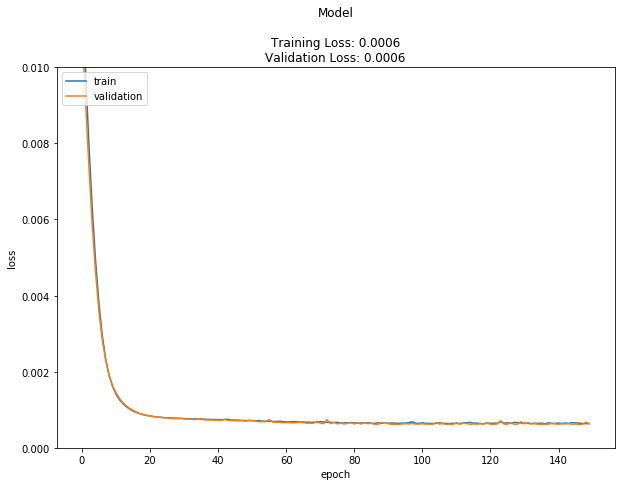

In [715]:
#print(history.history.keys())
fig, ax = plt.subplots(figsize=(10,7))   
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model\n' +
          '\nTraining Loss: ' +
          str(round(history.history['loss'][-1],4)) + 
          '\nValidation Loss: ' +
          str(round(history.history['val_loss'][-1],4))
         )
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
axes = plt.gca()
axes.set_ylim([0,0.01])
model.summary()
plt.show()

## Test Model

In [716]:
dfTest = pd.read_pickle('../Pickle/testing.pkl')
dfTestDrop = dfTest.drop(colsToDropAll, axis=1)
dfTestDrop.head()

,meanScore,bookAlignment,containerOrientation,containerStrategy,infillMaxHeight,infillVolumePriority,maxCantilever,minimumItems,1-1,1-10,...,7-19,7-2,7-20,7-3,7-4,7-5,7-6,7-7,7-8,7-9
0,0.632487,2,0,2,150,0,20,30,1,0,...,1,1,1,1,1,0,0,0,0,0
1,0.639504,0,0,2,150,0,10,30,1,1,...,1,1,1,1,1,0,0,0,1,0
2,0.274226,0,0,1,150,0,10,40,1,0,...,1,1,1,1,1,0,1,1,0,0
3,0.504528,0,0,1,150,0,20,50,1,0,...,1,1,1,1,1,0,0,0,0,0
4,0.652322,2,0,2,150,0,0,55,1,0,...,1,1,1,1,1,1,0,0,0,0


In [717]:
tBookAlignment = dfTestDrop.pop('bookAlignment')
dfTestDrop['bAlignFront'] = (tBookAlignment == 0)*1.0
dfTestDrop['bAlignBack'] = (tBookAlignment == 1)*1.0
dfTestDrop['bAlignMax'] = (tBookAlignment == 2)*1.0
dfTestDrop['bAlignDeep'] = (tBookAlignment == 3)*1.0

In [718]:
tContainerOrient = dfTestDrop.pop('containerOrientation')
dfTestDrop['cOrientAll'] = (tContainerOrient == 0)*1.0
dfTestDrop['cOrientLHW'] = (tContainerOrient == 1)*1.0
dfTestDrop['cOrientWHL'] = (tContainerOrient == 2)*1.0
dfTestDrop['cOrientWLH'] = (tContainerOrient == 3)*1.0
dfTestDrop['cOrientHLW'] = (tContainerOrient == 4)*1.0
dfTestDrop['cOrientLWH'] = (tContainerOrient == 5)*1.0
dfTestDrop['cOrientHWL'] = (tContainerOrient == 5)*1.0

In [719]:
tContainerStrategy = dfTestDrop.pop('containerStrategy')
dfTestDrop['cStratGreedy'] = (tContainerStrategy == 0)*1.0
dfTestDrop['cStratGroups'] = (tContainerStrategy == 1)*1.0
dfTestDrop['cStratMin'] = (tContainerStrategy == 2)*1.0

In [720]:
tInfillVol = dfTestDrop.pop('infillVolumePriority')
dfTestDrop['iVolMax'] = (tInfillVol == 0)*1.0
dfTestDrop['iVolVert'] = (tInfillVol == 1)*1.0
dfTestDrop['iVolHoriz'] = (tInfillVol == 2)*1.0
dfTestDrop['iVolVOnly'] = (tInfillVol == 3)*1.0
dfTestDrop['iVolHOnly'] = (tInfillVol == 4)*1.0

In [721]:
dfTestDrop['infillMaxHeight'] = dfTestDrop['infillMaxHeight'].apply(lambda x: x/1000)
dfTestDrop['maxCantilever'] = dfTestDrop['maxCantilever'].apply(lambda x: x/100)
dfTestDrop['minimumItems'] = dfTestDrop['minimumItems'].apply(lambda x: x/100)

In [722]:
dfTestDrop.head()
#dfTestDrop.columns.tolist()

,meanScore,infillMaxHeight,maxCantilever,minimumItems,1-1,1-10,1-11,1-12,1-13,1-14,...,cOrientLWH,cOrientHWL,cStratGreedy,cStratGroups,cStratMin,iVolMax,iVolVert,iVolHoriz,iVolVOnly,iVolHOnly
0,0.632487,0.15,0.2,0.30,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.639504,0.15,0.1,0.30,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.274226,0.15,0.1,0.40,1,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.504528,0.15,0.2,0.50,1,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.652322,0.15,0.0,0.55,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [723]:
test_x = dfTestDrop
actual_y = test_x.pop('meanScore')

In [724]:
predict_y = model.predict(test_x)

In [725]:
test_x.head(1)

,infillMaxHeight,maxCantilever,minimumItems,1-1,1-10,1-11,1-12,1-13,1-14,1-15,...,cOrientLWH,cOrientHWL,cStratGreedy,cStratGroups,cStratMin,iVolMax,iVolVert,iVolHoriz,iVolVOnly,iVolHOnly
0,0.15,0.2,0.3,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [726]:
test_x.iloc[[0]]

,infillMaxHeight,maxCantilever,minimumItems,1-1,1-10,1-11,1-12,1-13,1-14,1-15,...,cOrientLWH,cOrientHWL,cStratGreedy,cStratGroups,cStratMin,iVolMax,iVolVert,iVolHoriz,iVolVOnly,iVolHOnly
0,0.15,0.2,0.3,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [727]:
c = 10

In [728]:
actual_y[c]

0.6505354589629441

In [729]:
model.predict(test_x.iloc[[c]])

array([[0.65530676]], dtype=float32)

In [730]:
type(actual_y)

pandas.core.series.Series

In [731]:
dfResults = pd.DataFrame(actual_y)
dfResults['predictedScore'] = predict_y
dfResults['Error'] = dfResults['meanScore'] - dfResults['predictedScore']
dfResults

,meanScore,predictedScore,Error
0,0.632487,0.630126,0.002361
1,0.639504,0.636425,0.003079
2,0.274226,0.644021,-0.369795
3,0.504528,0.679783,-0.175255
4,0.652322,0.640455,0.011867
5,0.428185,0.647922,-0.219737
6,0.421270,0.633361,-0.212091
7,0.443509,0.638573,-0.195064
8,0.647284,0.644570,0.002715
9,0.643235,0.635755,0.007480


(0, 1)

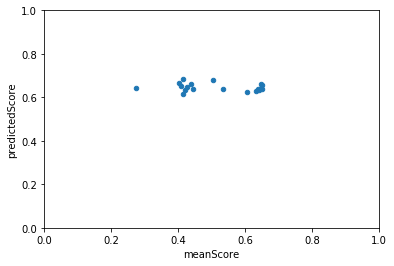

In [732]:
ax = dfResults.plot.scatter(x='meanScore',y='predictedScore')
ax.set_xlim(0,1)
ax.set_ylim(0,1)